In [1]:
# Importing Relevant Libraries
import numpy 
import pandas
import time
import matplotlib.pyplot
import pylab
import collections
import pymongo
import psycopg2
import paho.mqtt.client as mqtt

from IPython import display
from pandas import datetime
from datetime import timedelta
from pymongo import MongoClient
from scipy import stats

In [1]:
import plotly.graph_objects as go
import plotly as py

In [2]:
# Set up MongoDB Client
client_mqtt = mqtt.Client()

# Set up NodeMCU Client
client_mongo = MongoClient('192.168.1.5')
ccd_database = client_mongo['snr_ccd']

In [3]:
#Function to control the air-conditioning unit
def temperature_control(selection, increment = 4, connection_type = "192.168.1.27", AC_Name='A1F'):
    # Commands to control the AC via IR transmitter
    temperature_up = "/"+str(AC_Name)+"/ac/temp/up"
    temperature_down = "/"+str(AC_Name)+"/ac/temp/down"
    fan_high = "/"+str(AC_Name)+"/ac/fan/high"
    fan_medium = "/"+str(AC_Name)+"/ac/fan/medium"
    fan_low = "/"+str(AC_Name)+"/ac/fan/low"
    toggle_power = "/"+str(AC_Name)+"/ac/power/onoff"
    
    # Establish connection with NodeMCU
    client_mqtt.connect(connection_type, 1883, 60)
    time.sleep(2)
    
    # Implement the various functionalities
    if(selection == 'increase'):
        for count in range(increment):
            time.sleep(3)
            client_mqtt.publish("/spring/gateway/edge", temperature_up)
            time.sleep(3)
    
    elif(selection == 'decrease'):
        for count in range(increment):
            time.sleep(3)
            client_mqtt.publish("/spring/gateway/edge", temperature_down)
            time.sleep(3)
    
    elif(selection == 'Fan-High'):
        time.sleep(3)
        client_mqtt.publish("/spring/gateway/edge", fan_high)
        time.sleep(3)
        
    elif(selection == 'Fan-Medium'):
        time.sleep(3)
        client_mqtt.publish("/spring/gateway/edge", fan_medium)
        time.sleep(3)        
    
    elif(selection == 'Fan-Low'):
        time.sleep(3)
        client_mqtt.publish("/spring/gateway/edge", fan_low)
        time.sleep(3)     
        
    elif(selection == 'Power'):
        time.sleep(3)
        client_mqtt.publish("/spring/gateway/edge", toggle_power)
        time.sleep(3)         
    
    # Disconnect from the client
    time.sleep(2)
    client_mqtt.disconnect()

In [9]:
#Function to plot the rolling average and control the temperature accordingly
def plot_roll_avg(window = 10, lag = 6, standard_temp = 24, no_of_sensors = 3, data_flow_rate_minutes = 1):
    #Display the time at which the clock is being started
    print('Clock started at',datetime.now().strftime('%m/%d/%Y %H:%M'),'\n')

    i = 0
    qu = collections.deque()
    t_critical = stats.t.ppf(0.95,((no_of_sensors*window)-1)) #T-value for 1-tailed test with 95% confidence
    dates = collections.deque()
    colors_list = collections.deque()
    means = collections.deque()
    
    dataframe = ccd_database.temp_mqtt_test
    dataframe = pandas.DataFrame(list(dataframe.find()))
    #Get the time 1 minute prior to the current time
    now = dataframe.index[dataframe['date_time'] == (datetime.now() - timedelta(minutes = 3)).strftime('%m/%d/%Y %H:%M')].tolist()
    now = int(now[0])
    dataframe = dataframe.iloc[now:]
    dataframe.reset_index(drop=True, inplace=True)
    sufficient_data_received = 0
    change = 0
    change_log = 0
    standard_deviation = 2.5
    sensor_names = list()
    temperatures = list()
        
    while(True):
        time.sleep(1)
        if(sufficient_data_received==0):
            dataframe = ccd_database.temp_mqtt_test
            dataframe = pandas.DataFrame(list(dataframe.find()))
            dataframe['temperature'] = dataframe['temperature'].values
            dataframe = dataframe.iloc[now:]
            dataframe.reset_index(drop=True, inplace=True)
            dataframe = pandas.DataFrame(dataframe)
            dataframe = dataframe.pivot_table(index = 'date_time', columns='position', values='temperature', aggfunc=numpy.min)
            x = dataframe.index.values
            dataframe.reset_index(drop=True, inplace=True)
            sensor_names = list(dataframe.columns)
            dataframe[sensor_names] = dataframe[sensor_names].astype('float')
            dataframe.dropna(how='any', inplace=True)
            print('T -',(window-i))
            qu.append(numpy.mean(dataframe[sensor_names].iloc[i].values))
            #Wait 60 seconds to get the next temperature after 60 seconds:
            time.sleep(60*data_flow_rate_minutes)
                
        if(i==len(dataframe)-1):
            time.sleep(180)
            if(i==len(dataframe)-1):
                time.sleep(120)
                if(i==len(dataframe)-1):
                    break

        if(sufficient_data_received>=1):
            for i in range(i,(i+lag)):
                dataframe = ccd_database.temp_mqtt_test
                dataframe = pandas.DataFrame(list(dataframe.find()))
                dataframe['temperature'] = dataframe['temperature'].values
                dataframe = dataframe.iloc[now:]
                dataframe.reset_index(drop=True, inplace=True)
                dataframe = pandas.DataFrame(dataframe)
                dataframe = dataframe.pivot_table(index = 'date_time', columns='position', values='temperature', aggfunc=numpy.min)
                x = dataframe.index.values
                dataframe.reset_index(drop=True, inplace=True)
                sensor_names = list(dataframe.columns)
                dataframe[sensor_names] = dataframe[sensor_names].astype('float')               
                dataframe.dropna(how='any', inplace=True)
                qu.append(numpy.mean(dataframe[sensor_names].iloc[i].values))
                #Wait 60 seconds to get the next temperature after 60 seconds:
                time.sleep(60*data_flow_rate_minutes)

        #print('data stream:', qu)
        if(len(qu)>=window):
            sufficient_data_received = sufficient_data_received+1
            dates.append(x[i])
            list_of_actionable_data = list(qu)
            list_of_actionable_data = list_of_actionable_data[len(qu)-window:len(qu)]
            avg = numpy.mean(list_of_actionable_data)
            means.append(avg)
            t=(avg-standard_temp)/(standard_deviation/numpy.sqrt((no_of_sensors*window))) #30 = values from 3 sensors.
            
            if(abs(t) <= t_critical) and (change == 1):
                standard_deviation = 1.5
                t=(avg-standard_temp)/(standard_deviation/numpy.sqrt((no_of_sensors*window)))
            standard_deviation = 2.5
            
            if(abs(t) > t_critical):
                colors_list.append('red')
                if change == 0 and t>=0:
                    change = 1
                    temperature_control('decrease')
                    print('Temperature decreased at:',datetime.now().strftime('%H:%M:%S'))
            
            elif(abs(t) <= t_critical):
                colors_list.append('green')
                if change == 1:
                    change = 0
                    temperature_control('increase')
                    print('Temperature increased at:',datetime.now().strftime('%H:%M:%S'))
            colors = list(colors_list)
            
            #Plot by value at the given time:
            for j in range(len(colors_list)):
                if colors[j] == 'red':
                    matplotlib.pyplot.scatter(dates[j][11:16],means[j], s = 5.7, c = 'r')
                elif colors[j] == 'green':
                    matplotlib.pyplot.scatter(dates[j][11:16],means[j], s = 5.7, c = 'g')
            
            matplotlib.pyplot.gcf().autofmt_xdate()
            display.display(pylab.gcf())
            display.clear_output(wait=True)
            time.sleep(1)
            colors.clear()
            list_of_actionable_data.clear()
        matplotlib.pyplot.close()
        temperatures.clear()
        i = i+1

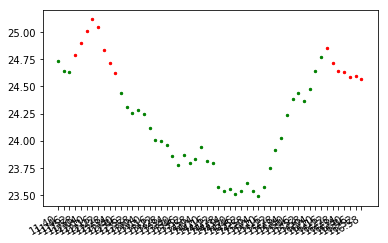

In [ ]:
plot_roll_avg(window = 10, lag = 6, standard_temp = 24)